In [78]:
from NGS import HiCTools as HT
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cooler
from scipy.stats import multivariate_normal
import matplotlib.patches as patches
import seaborn as sbn

# Fix path to pbgzip

In [83]:
environment_path = f"/users/michael.mitter/.conda/envs/NGStest/bin/"

# get pre-set PATH environment variable
original_os_path = os.environ.get('PATH')
os_path = original_os_path

# guard PATH against multiple prepending
if environment_path not in original_os_path:
    os_path = environment_path + ':' + original_os_path
%env PATH=$os_path

env: PATH=/users/michael.mitter/.conda/envs/NGStest/bin/:/software/2020/software/anaconda3/2019.03/bin;/software/2020/software/anaconda3/2019.03/condabin;/software/2020/software/anaconda3/2019.03/library/bin;/software/2020/software/anaconda3/2019.03/bin;/software/2020/software/anaconda3/2019.03/condabin;/software/2020/software/anaconda3/2019.03/library/bin;/software/2020/software/anaconda3/2019.03/bin;/software/2020/software/anaconda3/2019.03/condabin;/software/2020/software/anaconda3/2019.03/library/bin;/software/2020/software/anaconda3/2019.03/bin;/software/2020/software/anaconda3/2019.03/condabin;/software/2020/software/anaconda3/2019.03/library/bin;/users/michael.mitter/.vscode-server/bin/2aae1f26c72891c399f860409176fe435a154b13/bin:/users/michael.mitter/.conda/envs/gitEnv/bin/:/users/michael.mitter/.vscode-server/bin/2aae1f26c72891c399f860409176fe435a154b13/bin:/software/2020/software/anaconda3/2019.03/condabin:/users/michael.mitter/.conda/envs/gitEnv/bin/:/software/system/utils:/

# Define functions

In [70]:
def generate2dGauss(mean, variance, gridsize=10, spacing=0.2):
    # define grid
    x, y = np.mgrid[-gridsize:gridsize:spacing, -gridsize:gridsize:spacing]
    # get position vector
    pos = np.dstack((x, y))
    # get multivariate_normal distribution with given mean and covariance matrix
    rv1 = multivariate_normal(mean, variance)
    # get matrix and blank out diagonal
    rvmat1 = rv1.pdf(pos)
    rvmat1[np.diag_indices_from(rvmat1)] = np.nan
    return rvmat1

# Get chromosomal arms
Connects to UCSC and gets chromosome sizes as well as centromeres for hg19 to compute chromosomal arms.

In [3]:
arms  = HT.getArmsHg19()

In [9]:
arms.head()

,chrom,start,end
0,chr1,0,125200000
1,chr1,125200000,249250621
2,chr2,0,93650000
3,chr2,93650000,243199373
4,chr3,0,90900000


# Get Expected
Calculates the expected amount of contact frequency for each diagonal.

## Load in cooler

In [6]:
c = cooler.Cooler("/groups/gerlich/experiments/Experiments_004800/004812/Sequencing_data/Pooled_FC_1_2/cooler/G2.fc_1_2.trans.1000.mcool::/resolutions/100000")

In [7]:
expected = HT.getExpected(c, arms, proc=2)

In [10]:
expected.head()

,chrom,start,end,diag,n_valid,count.sum,balanced.sum,balanced.avg
0,chr1,0,125200000,0,1036,0.0,0.000000,0.000000
1,chr1,0,125200000,1,993,0.0,0.000000,0.000000
2,chr1,0,125200000,2,979,10743.0,7.892122,0.008061
3,chr1,0,125200000,3,972,9525.0,6.910876,0.007110
4,chr1,0,125200000,4,960,8117.0,5.849356,0.006093


- diagonal refers to the number of the specific diagonal
- n_valid refers to numnber of valid Hi-C bins
- count.sum refers to number reads on each diagonal
- balanced.sum refers to the cumulative contact frequency for the specific diagonal
- balanced.avg refers to contact frequency per bin, this is the "expected value"

# Assign regions
Constructs a region around chromosomal locations for use in pileups

## 1d features

In [18]:
regions = pd.read_csv("/groups/gerlich/experiments/Experiments_004400/004472/Datasets/Sor_clean.bed", sep="\t", header=None)[[0, 1, 2]]
regions.loc[:, "mid"] = (regions[1] + regions[2])//2
regions.head()

,0,1,2,mid
0,chr1,10027,10525,10276
1,chr1,237604,237907,237755
2,chr1,521435,521730,521582
3,chr1,950640,951278,950959
4,chr1,1057328,1057983,1057655


In [23]:
windows = HT.assignRegions(400000, 100000, regions[0], regions["mid"], arms).dropna()
windows = windows.loc[(windows["start"] > 0) & (windows["end"] > 0), :]
windows.head()

,chrom,start,end,lo,hi,region
2,chr1,100000,1000000,1,10,chr1:0-125200000
3,chr1,500000,1400000,5,14,chr1:0-125200000
4,chr1,600000,1500000,6,15,chr1:0-125200000
5,chr1,800000,1700000,8,17,chr1:0-125200000
6,chr1,1000000,1900000,10,19,chr1:0-125200000


## 2d features
With 2d I mean defined by the coordinates, not only being on diagonal

In [36]:
loops = pd.read_csv("/groups/gerlich/experiments/Experiments_004400/004472/Datasets/GSE63525_HeLa_HiCCUPS_looplist.txt", sep="\t")[["chr1", "x1", "x2", "chr2","y1", "y2"]]
loops.loc[:, "pos1"] = (loops["x1"] + loops["x2"])//2
loops.loc[:, "pos2"] = (loops["y1"] + loops["y2"])//2
loops.loc[:, "chr1"] = ["chr" + str(i) for i in loops["chr1"]] # fix chromosome names
loops.loc[:, "chr2"] = ["chr" + str(i) for i in loops["chr2"]] # fix chromosome names
loops.head()

,chr1,x1,x2,chr2,y1,y2,pos1,pos2
0,chr10,101610000,101620000,chr10,101800000,101810000,101615000,101805000
1,chr10,102100000,102110000,chr10,102190000,102200000,102105000,102195000
2,chr10,103360000,103370000,chr10,103540000,103550000,103365000,103545000
3,chr10,105470000,105480000,chr10,105610000,105620000,105475000,105615000
4,chr10,109750000,109755000,chr10,109930000,109935000,109752500,109932500


In [37]:
loopWindows = HT.assignRegions2d(400000, 100000, loops["chr1"], loops["pos1"], loops["chr2"], loops["pos2"], arms)

In [38]:
loopWindows.head()

,chrom1,start1,end1,chrom2,start2,end2,region
0,chr10,101200000,102100000,chr10,101400000,102300000,chr10:40150000-135534747
1,chr10,101700000,102600000,chr10,101700000,102600000,chr10:40150000-135534747
2,chr10,102900000,103800000,chr10,103100000,104000000,chr10:40150000-135534747
3,chr10,105000000,105900000,chr10,105200000,106100000,chr10:40150000-135534747
4,chr10,109300000,110200000,chr10,109500000,110400000,chr10:40150000-135534747


# Do pileup obs/exp

## With collapsing

In [58]:
pile = HT.doPileupObsExp(c, expected, windows)

In [59]:
pile

array([[       inf,        inf, 0.98776544, 1.03853326, 1.08233088,
        0.9807215 , 0.93241882, 0.92005139, 0.90948377],
       [       inf,        inf,        inf, 1.0422076 , 1.07919545,
        0.98604907, 0.9346831 , 0.91811768, 0.92366845],
       [0.98776544,        inf,        inf,        inf, 1.08204432,
        0.98994433, 0.93945984, 0.93774886, 0.93101527],
       [1.03853326, 1.0422076 ,        inf,        inf,        inf,
        1.02732275, 0.99381698, 0.97910174, 0.97732395],
       [1.08233088, 1.07919545, 1.08204432,        inf,        inf,
               inf, 1.08826168, 1.08474018, 1.08635626],
       [0.9807215 , 0.98604907, 0.98994433, 1.02732275,        inf,
               inf,        inf, 1.04320924, 1.04315134],
       [0.93241882, 0.9346831 , 0.93945984, 0.99381698, 1.08826168,
               inf,        inf,        inf, 0.99212708],
       [0.92005139, 0.91811768, 0.93774886, 0.97910174, 1.08474018,
        1.04320924,        inf,        inf,        inf],


In [60]:
pile.shape

(9, 9)

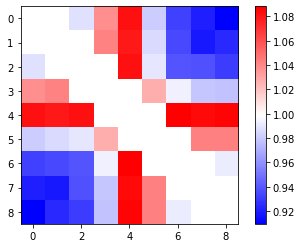

In [61]:
f, ax = plt.subplots()
im = ax.imshow(pile, cmap="bwr")
f.colorbar(im, ax=ax)
plt.show()

## Without collapsing

In [97]:
pile = HT.doPileupObsExp(c, expected, windows, collapse=False)

In [63]:
pile.shape

(9, 9, 40347)

- Pile now holds all 9 x 9 windows for each individual position

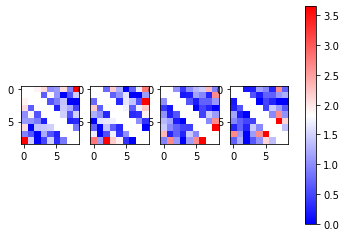

In [64]:
f, ax = plt.subplots(1, 4)
for index, i in enumerate(range(80, 84)):
    im = ax[index].imshow(pile[:, :, i], cmap="bwr")
f.colorbar(im, ax=ax)
plt.show()

# Pile to Frame
Takes a non-collapsed pile and transforms it into a dataframe

In [98]:
frame = HT.pileToFrame(pile)

In [100]:
frame.dropna().head()

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
54,inf,inf,1.442750,0.924316,1.406237,1.707031,0.759016,2.709509,1.086434,inf,...,inf,1.086434,2.349782,2.228806,2.370757,1.992065,0.467448,1.647004,inf,inf
55,inf,inf,2.875759,1.047860,2.253263,0.695243,1.654504,2.655169,2.600023,inf,...,inf,2.600023,2.560128,1.609995,1.770916,1.204572,1.580617,1.892471,inf,inf
56,inf,inf,1.086405,1.945664,2.738931,1.188719,2.409137,2.560128,1.277126,inf,...,inf,1.277126,1.307384,1.891747,1.301658,1.198854,1.569045,1.999857,inf,inf
57,inf,inf,1.086405,1.945664,2.738931,1.188719,2.409137,2.560128,1.277126,inf,...,inf,1.277126,1.307384,1.891747,1.301658,1.198854,1.569045,1.999857,inf,inf
77,inf,inf,1.339534,1.458482,0.716402,0.774567,1.448438,0.653489,2.547698,inf,...,inf,2.547698,1.024557,0.000000,0.341979,1.039086,0.217170,0.612962,inf,inf


# Do Pileup ICCF
Same as do pileup obs/exp, just with corrected counts. Also here, one can do the pileup with and without collapsing.

In [65]:
pile = HT.doPileupICCF(c, windows)

In [66]:
pile

array([[0.00934509, 0.00972759, 0.00778578, 0.00707998, 0.00639228,
        0.00501527, 0.00411995, 0.00358334, 0.00309482],
       [0.00972759, 0.00930488, 0.00980669, 0.00821648, 0.0073698 ,
        0.0058224 , 0.00477951, 0.0040582 , 0.00359841],
       [0.00778578, 0.00980669, 0.00939655, 0.01023822, 0.00853919,
        0.00675687, 0.00554806, 0.00479644, 0.00411368],
       [0.00707998, 0.00821648, 0.01023822, 0.00976429, 0.01088911,
        0.00811145, 0.00678293, 0.00577646, 0.00499521],
       [0.00639228, 0.0073698 , 0.00853919, 0.01088911, 0.01084468,
        0.0109444 , 0.00859185, 0.00739379, 0.00641778],
       [0.00501527, 0.0058224 , 0.00675687, 0.00811145, 0.0109444 ,
        0.00972693, 0.01031447, 0.00822467, 0.00711671],
       [0.00411995, 0.00477951, 0.00554806, 0.00678293, 0.00859185,
        0.01031447, 0.00927034, 0.00981771, 0.00783057],
       [0.00358334, 0.0040582 , 0.00479644, 0.00577646, 0.00739379,
        0.00822467, 0.00981771, 0.00924601, 0.00970531],


In [67]:
pile.shape

(9, 9)

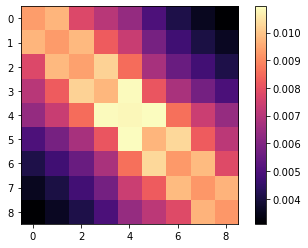

In [68]:
f, ax = plt.subplots()
im = ax.imshow(pile, cmap="magma")
f.colorbar(im, ax=ax)
plt.show()

# Sliding Diamond

## Generate fake data

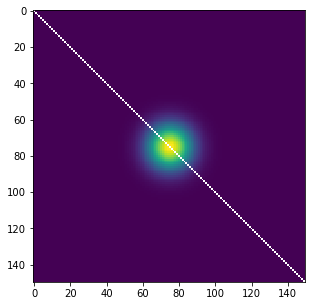

In [71]:
example = generate2dGauss(mean=[0, 0], variance=[[3, 0], [0, 3]], gridsize=15)

# plot figures
f, ax = plt.subplots(1, 1)
ax.imshow(example)
f.set_size_inches(5, 5)

## Look at diamond of different sizes

In [73]:
diamondDict = {}
for param in range(2, 70, 7):
    diamondDict[param] = patches.Rectangle((75-param//2,75-param//2),param,param,linewidth=1,edgecolor='r',facecolor='none')

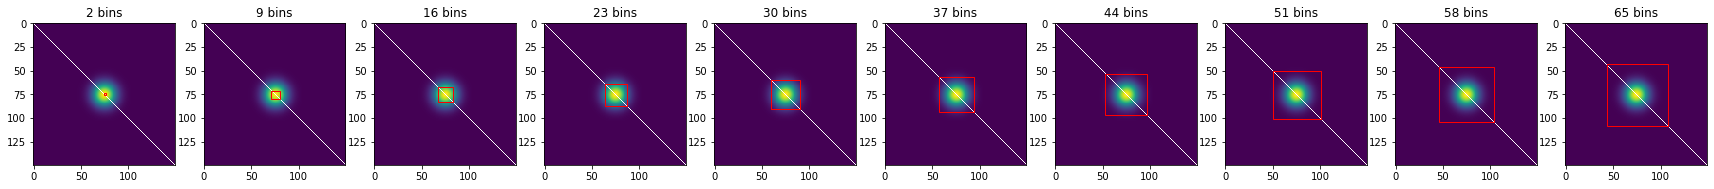

In [74]:
# plot figures
f, ax = plt.subplots(1, len(diamondDict))
for index, param in enumerate(diamondDict):
    ax[index].imshow(example)
    ax[index].set(title=f"{param} bins")
    ax[index].add_patch(diamondDict[param])
f.set_size_inches(30, 5)

In [76]:
diamondVals = {}
for param in range(2, 70, 7):
    diamondVals[param] = HT.slidingDiamond(example, sideLen=param)


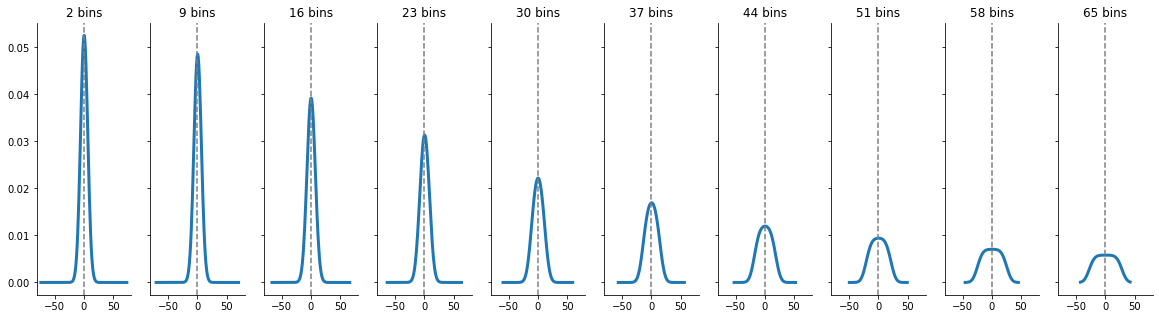

In [79]:
f, ax = plt.subplots(1, len(diamondVals), sharey=True, sharex=True)
for index, param in enumerate(diamondVals):
    ax[index].plot(diamondVals[param][0], diamondVals[param][1], lw=3)
    ax[index].set(title=f"{param} bins")
    ax[index].axvline(x=0, ls="--", color="grey")
sbn.despine()
f.set_size_inches(20, 5)
plt.show()

# Load pairs
Convenience function to load pairs data

## Define samples

In [92]:
pairDir = ("/groups/gerlich/experiments/Experiments_004700/004755/"
           "Sequencing_data/exp4661/pairs/")

# Prometaphase rep1 is from experiments 4638 and rep2 is from exp4615
pathMap = {"G2": pairDir,
           "Meta_Rep2": "/groups/gerlich/experiments/Experiments_004700/004755/Sequencing_data/exp4727/pairs/"}
barcodeMap = {"G2": "G2",
              "Meta_Rep2": "GTTTCG"}

## Load samples

In [94]:
pairs = {sample: {interType: HT.loadPairs(os.path.join(pathMap[sample], f"{barcodeMap[sample]}.{interType}.pairs.gz"))
                  for interType in ["cis", "trans"]}
         for sample in ["G2", "Meta_Rep2"]
         }

In [95]:
pairs["G2"]["cis"].head()

,readID,chrom1,pos1,chrom2,pos2,strand1,strand2,pair_type,mapq1,mapq2,n_AG_muts_phred0_1,n_AG_muts_phred0_2,n_AG_muts_phred30_1,n_AG_muts_phred30_2,n_TC_muts_phred0_1,n_TC_muts_phred0_2,n_TC_muts_phred30_1,n_TC_muts_phred30_2,n_matches_1,n_matches_2
0,A00700:28:H7W7NDRXX:2:2261:24117:34616,chr1,61777,chr1,62223,+,-,UU,32,60,0,0,0,0,3,5,3,5,246,250
1,A00700:32:H7MWFDRXX:2:2248:9272:24126,chr1,79484,chr1,79691,+,-,UU,37,36,2,2,2,2,0,0,0,0,208,210
2,A00700:28:H7W7NDRXX:2:2131:17481:25128,chr1,85502,chr1,86128,+,-,UU,37,43,0,0,0,0,4,2,4,2,250,250
3,A00700:32:H7MWFDRXX:1:2251:17472:33223,chr1,86862,chr1,157378921,+,-,UU,43,60,0,0,0,0,2,7,2,7,250,250
4,A00700:32:H7MWFDRXX:1:2139:3125:7467,chr1,88057,chr1,88491,+,-,UU,33,34,0,0,0,0,4,3,4,3,250,250


# Downsample pairs

In [96]:
pairsNew = HT.downSamplePairs(pairs)

# Get pairing score